# Тренировка модели YOLOv5 на датасете c мусором [TACO](http://tacodataset.org/)

## Клонирование репозитория с необходимой версией YOLOv5

In [1]:
!git clone https://github.com/brut0/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 3390, done.
remote: Total 3390 (delta 0), reused 0 (delta 0), pack-reused 3390
Receiving objects: 100% (3390/3390), 7.02 MiB | 13.21 MiB/s, done.
Resolving deltas: 100% (2273/2273), done.
/kaggle/working/yolov5


## Установка и подключение необходимых библиотек

In [2]:
!pip install pycocotools

     |████████████████████████████████| 106 kB 942 kB/s 
  Created wheel for pycocotools: filename=pycocotools-2.0.3-cp37-cp37m-linux_x86_64.whl size=273727 sha256=dc3c054d79e5f5b2041e814d69418512b3823a81851caf42dbaa57fc36ab5d29
  Stored in directory: /root/.cache/pip/wheels/a2/09/4f/27f24df9927973a2dd820c3fb741c49d1208b25eb5331181c5
Successfully built pycocotools
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install split-folders

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import os
import shutil
import numpy as np
import tqdm
import splitfolders
from pycocotools.coco import COCO
from IPython.display import Image

## Подготовка датасета

### read annotations.json

In [5]:
data_source = COCO(annotation_file='/kaggle/input/tacotrashdataset/data/annotations.json')
# !!! Для локального использования вне Kaggle необходимо скачать датасет

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


>      'Clear plastic bottle': 5
>      'Plastic bottle cap': 7
>      'Drink can': 12
>      'Other plastic': 29
>      'Plastic film': 36
>      'Other plastic wrapper': 39
>      'Unlabeled litter': 58
>      'Cigarette': 59

In [6]:
# remapping label id to 0~1
label_transfer = {5: 0, 12: 1}

img_ids = data_source.getImgIds()

catIds = data_source.getCatIds()
categories = data_source.loadCats(catIds)
categories.sort(key=lambda x: x['id'])
classes = {}
coco_labels = {}
coco_labels_inverse = {}
for c in categories:
    coco_labels[len(classes)] = c['id']
    coco_labels_inverse[c['id']] = len(classes)
    classes[c['name']] = len(classes)

class_num = {}

In [7]:
categories

[{'supercategory': 'Aluminium foil', 'id': 0, 'name': 'Aluminium foil'},
 {'supercategory': 'Battery', 'id': 1, 'name': 'Battery'},
 {'supercategory': 'Blister pack', 'id': 2, 'name': 'Aluminium blister pack'},
 {'supercategory': 'Blister pack', 'id': 3, 'name': 'Carded blister pack'},
 {'supercategory': 'Bottle', 'id': 4, 'name': 'Other plastic bottle'},
 {'supercategory': 'Bottle', 'id': 5, 'name': 'Clear plastic bottle'},
 {'supercategory': 'Bottle', 'id': 6, 'name': 'Glass bottle'},
 {'supercategory': 'Bottle cap', 'id': 7, 'name': 'Plastic bottle cap'},
 {'supercategory': 'Bottle cap', 'id': 8, 'name': 'Metal bottle cap'},
 {'supercategory': 'Broken glass', 'id': 9, 'name': 'Broken glass'},
 {'supercategory': 'Can', 'id': 10, 'name': 'Food Can'},
 {'supercategory': 'Can', 'id': 11, 'name': 'Aerosol'},
 {'supercategory': 'Can', 'id': 12, 'name': 'Drink can'},
 {'supercategory': 'Carton', 'id': 13, 'name': 'Toilet tube'},
 {'supercategory': 'Carton', 'id': 14, 'name': 'Other carton'

### Подготовка данных для обучения модели

In [8]:
!mkdir -p tmp/labels tmp/images
save_base_path  = 'tmp/labels/'
save_image_path = 'tmp/images/'

In [9]:
for index, img_id in tqdm.tqdm(enumerate(img_ids), desc='change .json file to .txt file'):
    img_info = data_source.loadImgs(img_id)[0]
    save_name = img_info['file_name'].replace('/', '_')
    file_name = save_name.split('.')[0]
    height = img_info['height']
    width = img_info['width']
    save_path = save_base_path + file_name + '.txt'
    is_exist = False
    with open(save_path, mode='w') as fp:
        annotation_id = data_source.getAnnIds(img_id)
        boxes = np.zeros((0, 5))
        if len(annotation_id) == 0:
            fp.write('')
            continue
        annotations = data_source.loadAnns(annotation_id)
        lines = ''
        for annotation in annotations:
            label = coco_labels_inverse[annotation['category_id']]
            if label in label_transfer.keys():
                is_exist = True
                box = annotation['bbox']
                if box[2] < 1 or box[3] < 1:
                    continue
                # top_x,top_y,width,height==>cen_x,cen_y,width,height
                box[0] = round((box[0] + box[2] / 2) / width, 6)
                box[1] = round((box[1] + box[3] / 2) / height, 6)
                box[2] = round(box[2] / width, 6)
                box[3] = round(box[3] / height, 6)
                label = label_transfer[label]
                if label not in class_num.keys():
                    class_num[label] = 0
                class_num[label] += 1
                lines = lines + str(label)
                for i in box:
                    lines += ' ' + str(i)
                lines += '\n'
        fp.writelines(lines)
    if is_exist:
        shutil.copy('/kaggle/input/tacotrashdataset/data/{}'.format(img_info['file_name']), os.path.join(save_image_path, save_name))
    else:
        os.remove(save_path)

change .json file to .txt file: 1500it [00:10, 137.45it/s]


### Деление на тренировочную, валидационную и тестовую выборки

In [10]:
!pip install split-folders

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [11]:
splitfolders.ratio('tmp', output="taco", seed=3407, ratio=(.8, 0.1,0.1)) 

Copying files: 708 files [00:00, 942.10 files/s]


### Display Test Images

In [12]:
!ls taco/test/images

batch_10_000035.jpg  batch_1_000025.jpg    batch_5_000052.JPG
batch_10_000075.jpg  batch_1_000048.jpg    batch_5_000070.JPG
batch_11_000048.jpg  batch_1_000062.JPG    batch_5_000103.JPG
batch_12_000012.jpg  batch_1_000110.JPG    batch_6_000066.JPG
batch_13_000027.jpg  batch_2_000018.JPG    batch_7_000010.JPG
batch_13_000036.jpg  batch_2_000027.JPG    batch_7_000091.JPG
batch_13_000042.jpg  batch_2_000048.JPG    batch_7_000109.JPG
batch_13_000088.jpg  batch_2_000049.JPG    batch_7_000118.JPG
batch_14_000048.jpg  batch_2_000088.JPG    batch_8_000011.jpg
batch_15_000062.jpg  batch_3_IMG_4932.JPG  batch_8_000013.jpg
batch_1_000014.jpg   batch_3_IMG_4941.JPG  batch_8_000077.jpg
batch_1_000024.jpg   batch_3_IMG_5053.JPG  batch_8_000087.jpg


## Train Model

>     $ python train.py --data coco.yaml --cfg yolov5s.yaml --weights '' --batch-size 64
                                             yolov5m                                40
                                             yolov5l                                24
                                             yolov5x                                16

In [13]:
!python train.py --img 640 --batch 1 --epochs 50 --data /kaggle/input/yolov5-taco-models/taco2.yaml --cfg models/yolov5s.yaml --weights /kaggle/input/yolov5-taco-models/taco2_epoch300_best.pt

2021-12-02 14:05:55.219697: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2
Scanning 'taco/train/labels' for images and labels... 283 found, 0 missing, 1 em
Scanning 'taco/train/labels.cache' for images and labels... 283 found, 0 missing
Scanning 'taco/val/labels' for images and labels... 35 found, 0 missing, 0 empty
Scanning 'taco/val/labels.cache' for images and labels... 35 found, 0 missing, 0

Analyzing anchors... anchors/target = 5.12, Best Possible Recall (BPR) = 1.0000
      0/49     1.41G   0.02345   0.01386  0.006052   0.04335         1       640
               Class      Images     Targets           P           R      mAP@.5
                 all          35          65       0.308       0.848       0.687        0.48
      1/49     1.41G   0.02341    0.0124  0.006449   0.04227         1       640
               Class      Images     Targets           P           R      mAP@.5
                 all          35

## Детектирование мусора

In [14]:
!cp runs/train/exp/weights/best.pt best.pt
!cp runs/train/exp/weights/best.pt ../best.pt

In [15]:
!python detect.py --weights best.pt --img 640 --conf 0.4 --source taco/test/images/batch_15_000062.jpg

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='taco/test/images/batch_15_000062.jpg', update=False, view_img=False, weights=['best.pt'])
Fusing layers... 
image 1/1 /kaggle/working/yolov5/taco/test/images/batch_15_000062.jpg: 480x640 1 Clear plastic bottles, Done. (0.012s)
Results saved to runs/detect/exp
Done. (0.146s)


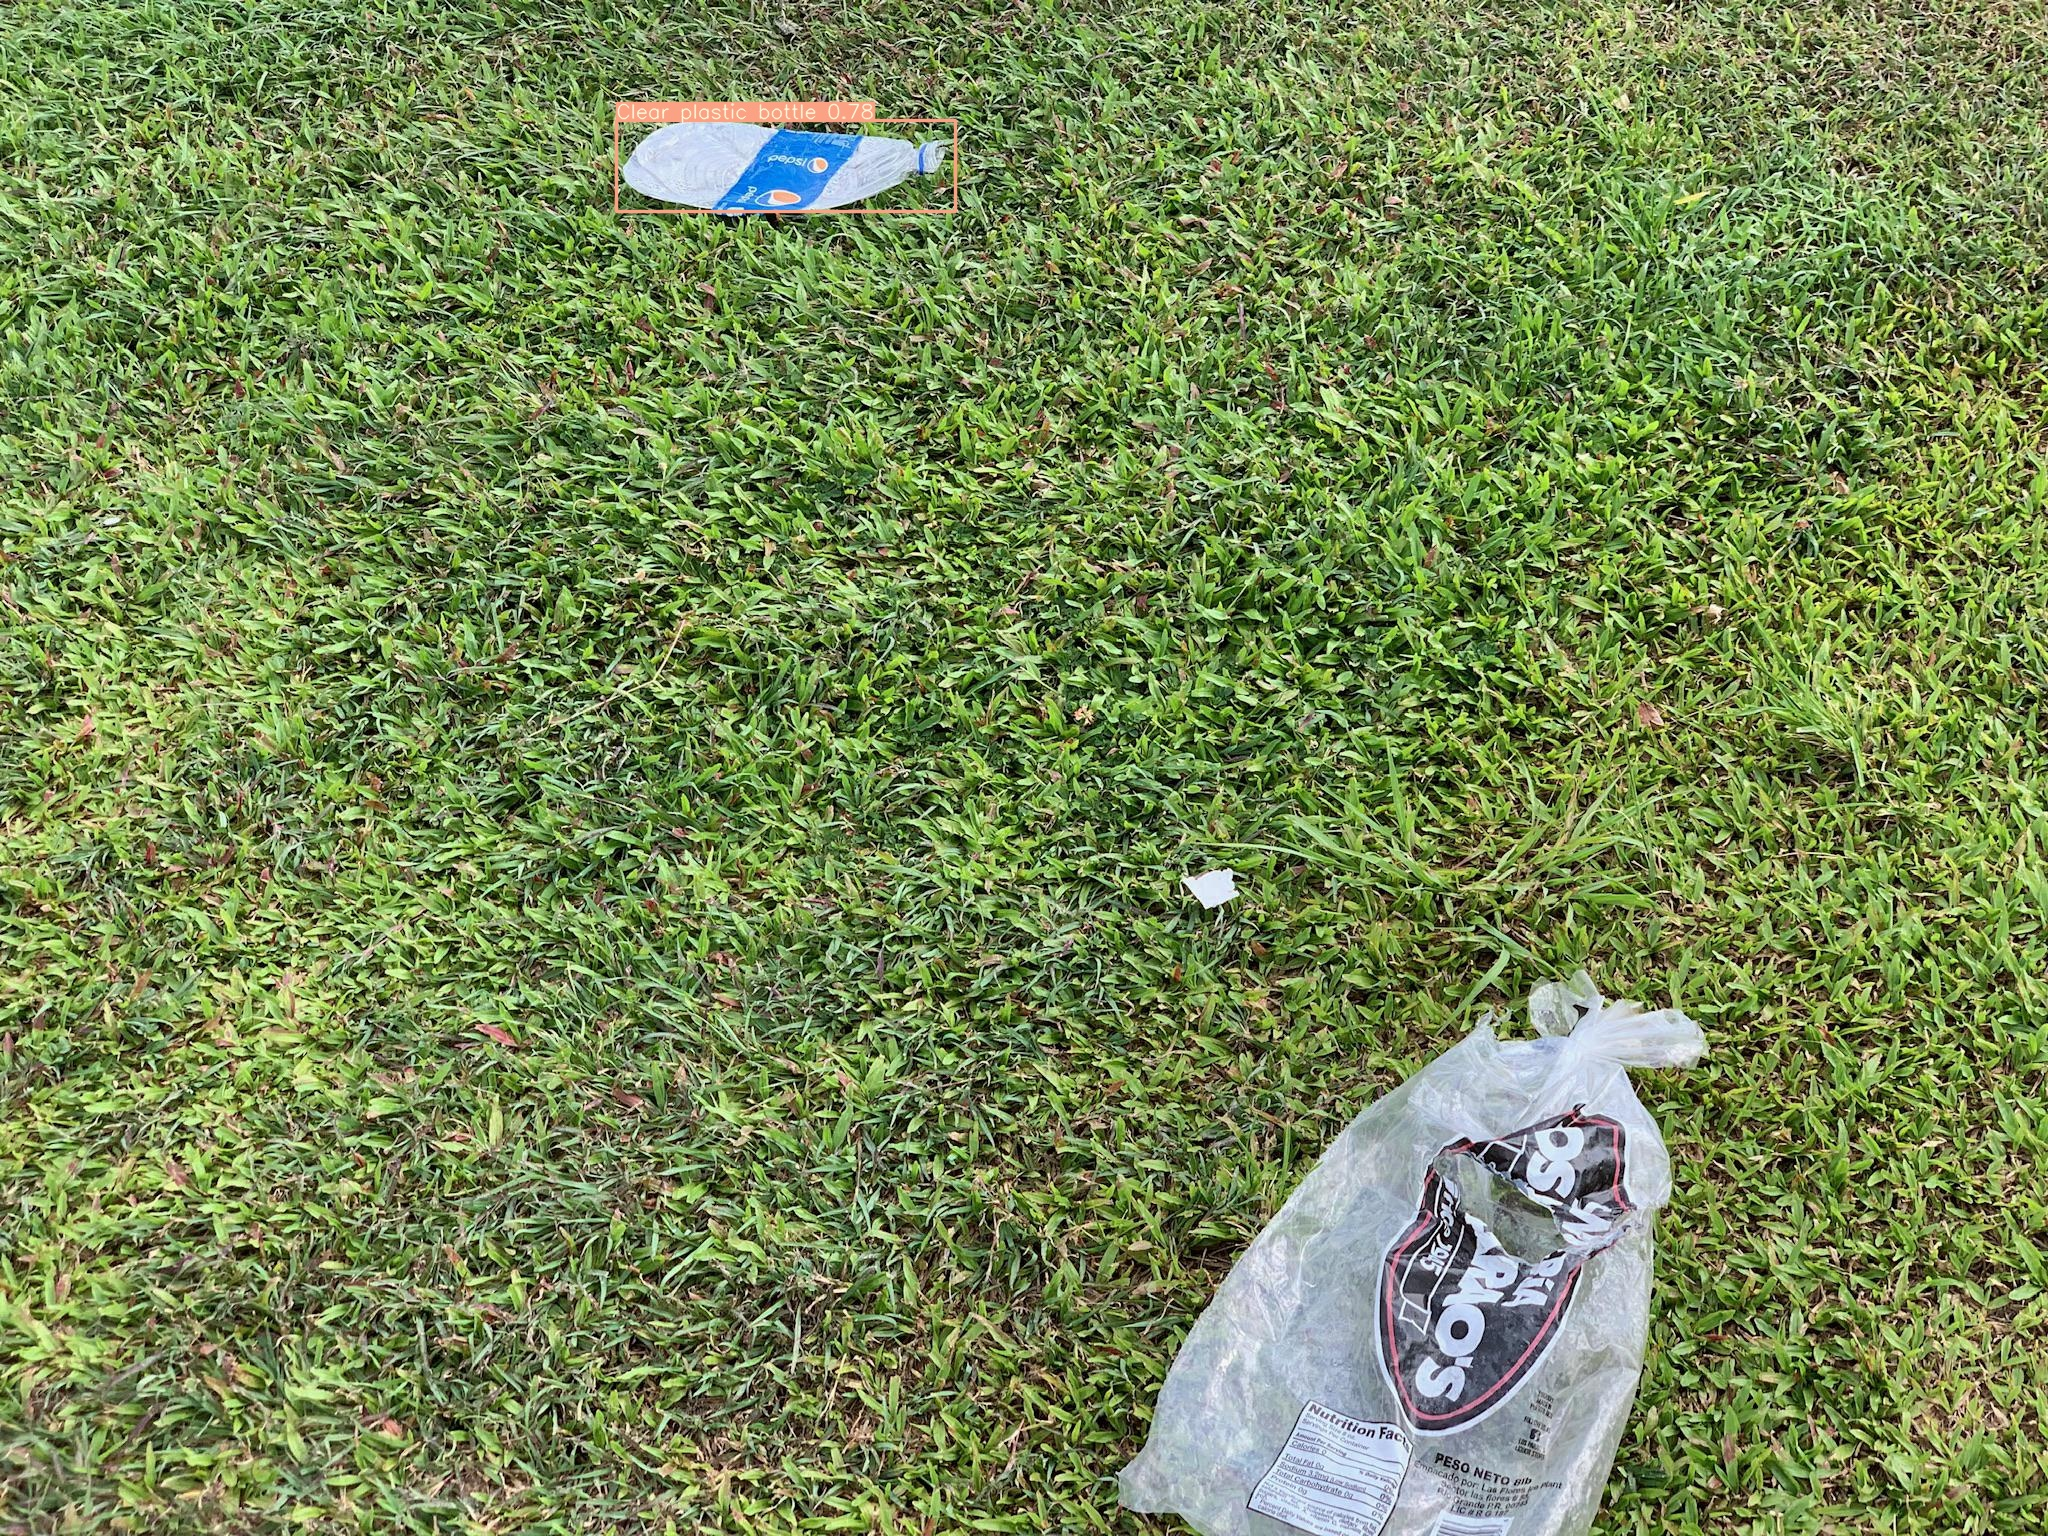

In [16]:
Image("runs/detect/exp/batch_15_000062.jpg")

In [17]:
!python detect.py --weights best.pt --img 640 --conf 0.4 --source taco/test/images/batch_8_000011.jpg

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='taco/test/images/batch_8_000011.jpg', update=False, view_img=False, weights=['best.pt'])
Fusing layers... 
image 1/1 /kaggle/working/yolov5/taco/test/images/batch_8_000011.jpg: 640x480 1 Clear plastic bottles, Done. (0.013s)
Results saved to runs/detect/exp2
Done. (0.253s)


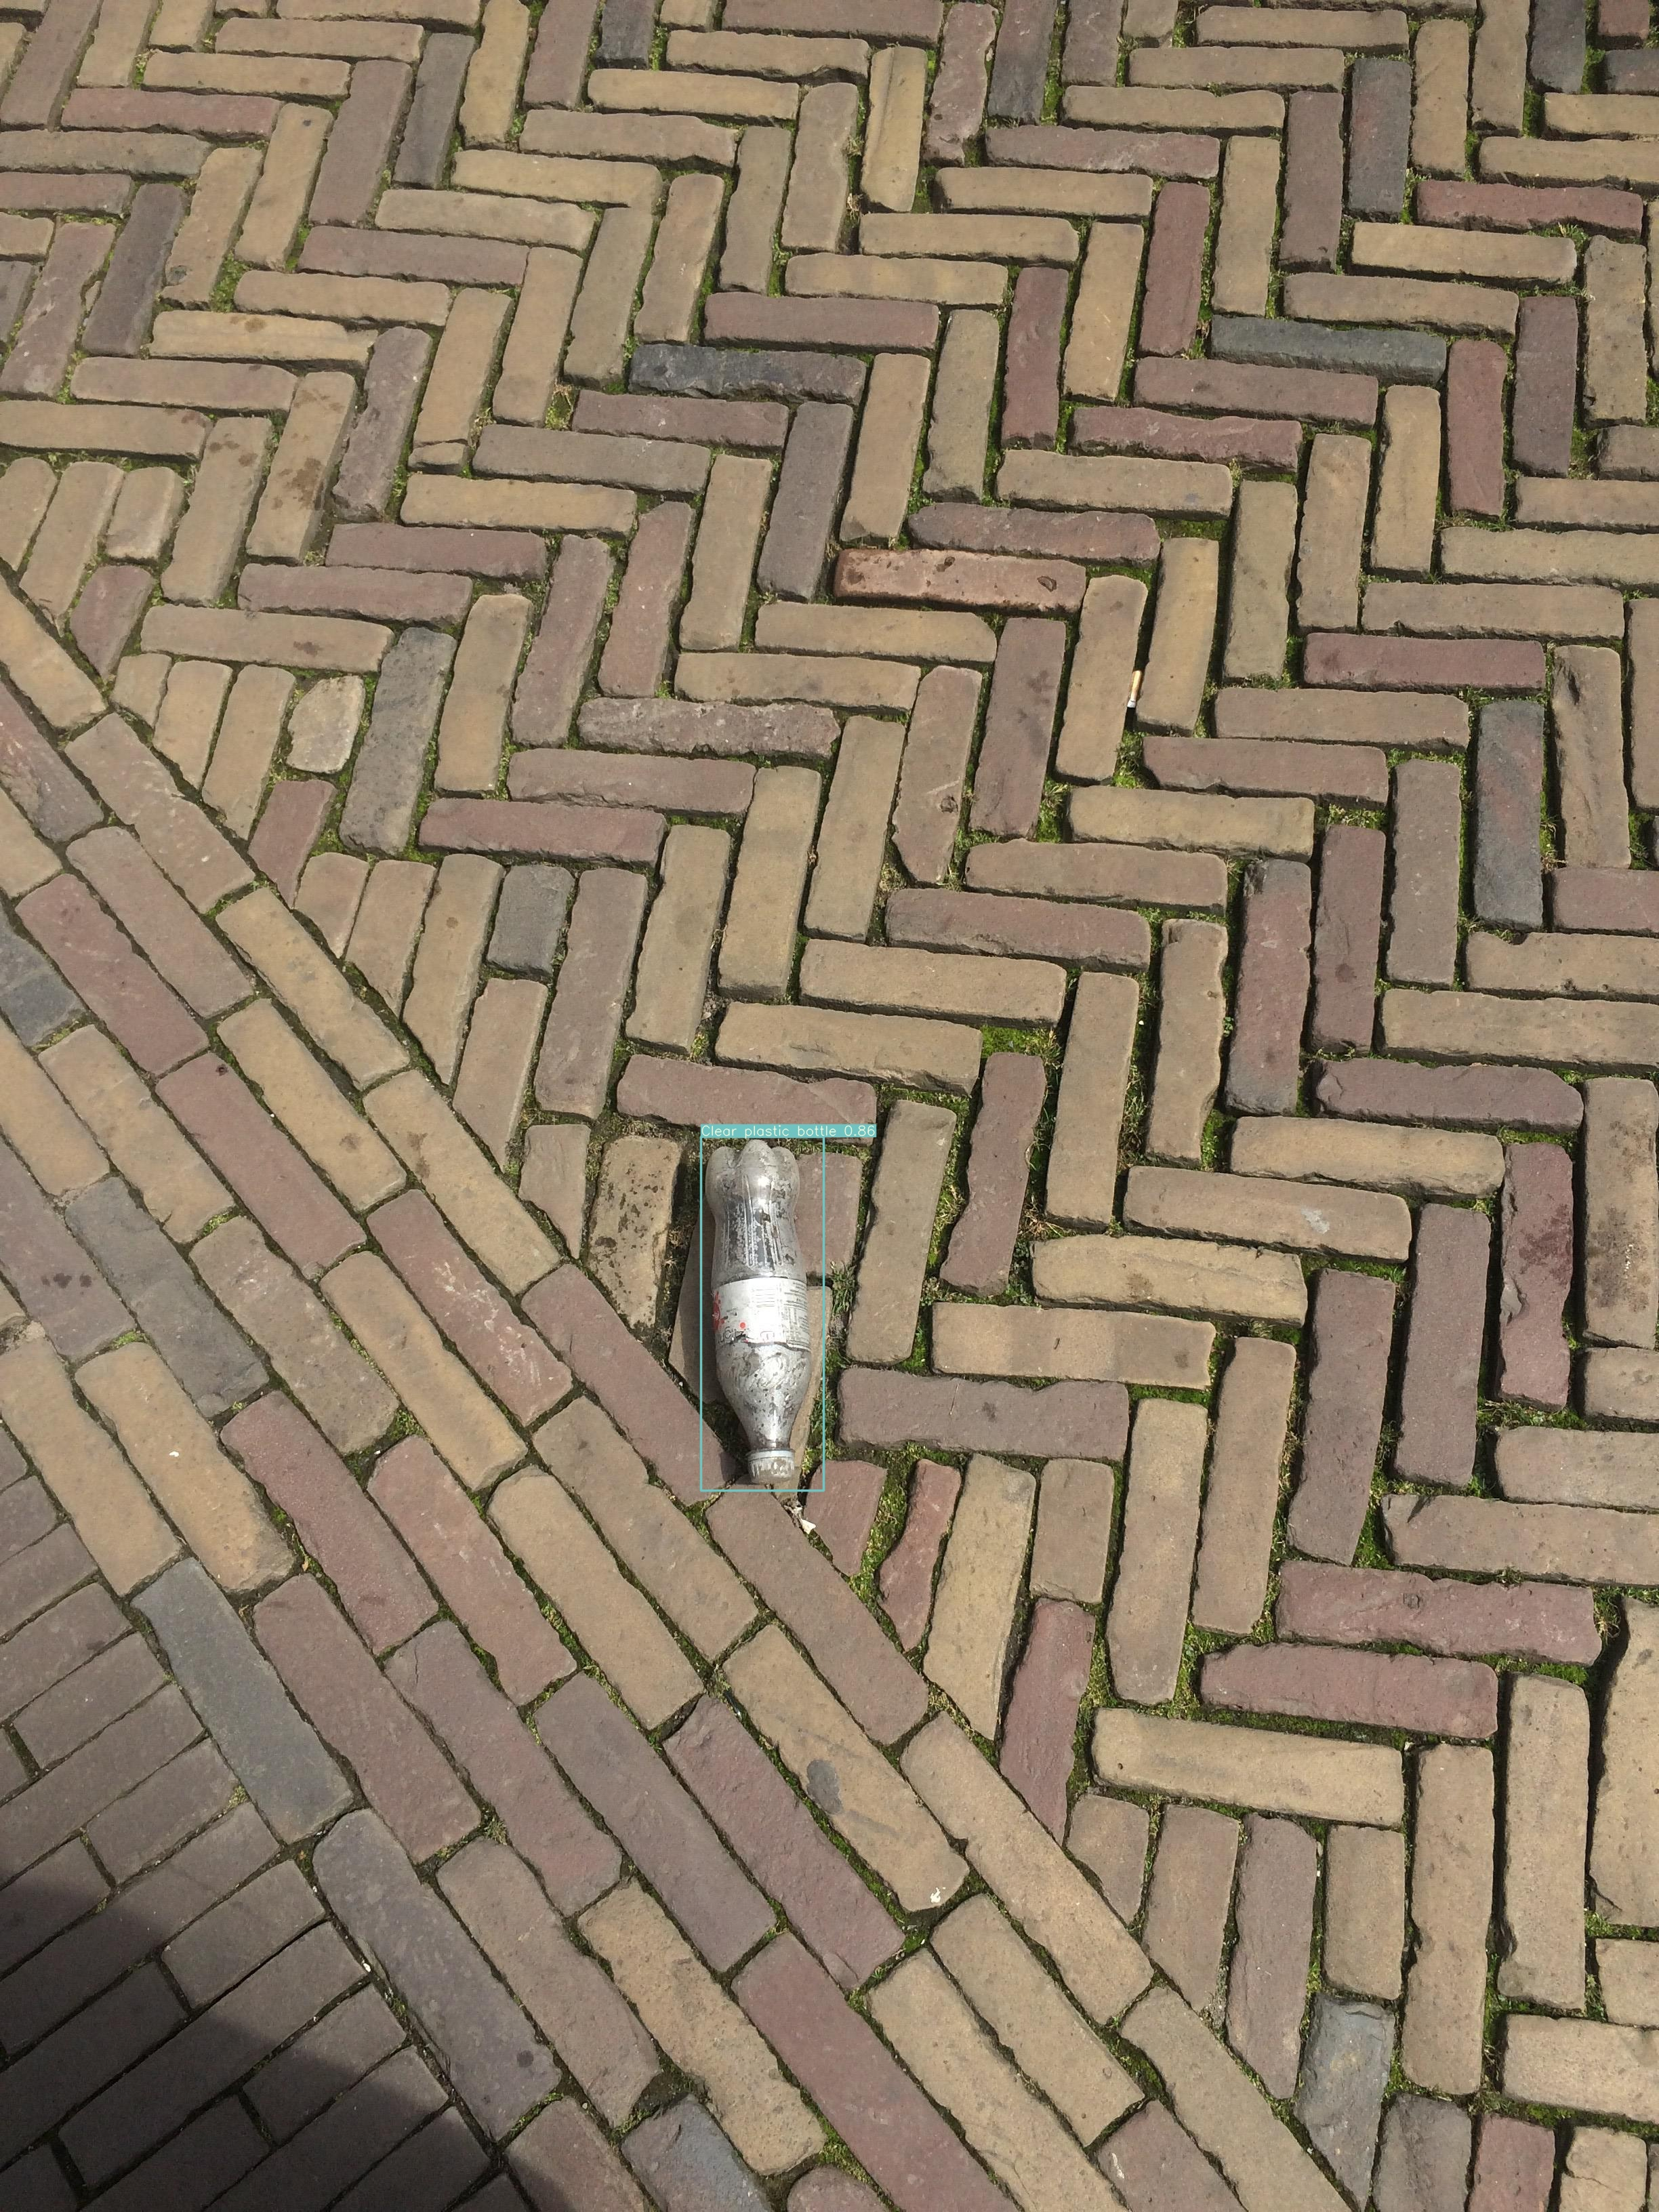

In [18]:
Image("runs/detect/exp2/batch_8_000011.jpg")